In [1]:
import cooler
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager
import glob

from scipy.stats import mannwhitneyu
from mpl_toolkits.axes_grid1 import make_axes_locatable
from skimage.filters import threshold_li, threshold_otsu
from scipy.stats import ttest_ind

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial'] 
plt.rcParams['pdf.fonttype'] = 42
font_files = font_manager.findSystemFonts(fontpaths='/cluster2/home/futing/miniforge3/envs/juicer/fonts/')
 
for file in font_files:
    font_manager.fontManager.addfont(file)

%cd /cluster2/home/futing/Project/panCancer/Analysis/conserve

/cluster2/home/futing/Project/panCancer/Analysis/conserve


# 完全匹配 BS

In [5]:
bin=pd.read_csv(f'/cluster2/home/futing/Project/panCancer/Analysis/conserve/BS537_col8_0104.tsv', sep="\t")


In [3]:
resinfo=pd.read_csv('/cluster2/home/futing/Project/panCancer/check/meta/PanmergedMeta_0104.txt',sep='\t')
resinfo.shape

(538, 12)

### cancer 的 BS

In [6]:
bin1=bin.drop(columns=resinfo.loc[resinfo['isctrl']==1,'ncell'].tolist()) # 删除 normal 细胞系
bin1.shape,bin.shape #((61775, 358), (61775, 415))

((61776, 442), (61776, 540))

In [10]:
bin1.head()

,chrom,start,end,AA86,ALL_PDX17,ALL_PDX19,ALL_PDX23,ALL_PDX29,ALL_PDX31,ALL_PDX34,...,CCRFCEM,JURKAT_3,MOLT4,RPMI8402,DND41,LEIOPT1063,LEIOPT848,LEIOPT886,LEIOPT916,LEIOPT967
0,chr1,0,50000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1,50000,100000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chr1,100000,150000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,chr1,150000,200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,chr1,200000,250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# 检查一下 MYC 的问题，一共 132 个细胞系存在
cells=bin1.loc[
    (bin1['chrom']=='chr8') & 
    (bin1['start']>=127700000) & 
    (bin1['end']<=127750000)
].dropna(axis=1).columns.tolist()[3:]  # 选取部分 boundary 查看

In [17]:
# 查看含有 MYC boundary的细胞系比例
MYC_pro=resinfo.loc[resinfo['ncell'].isin(cells),'cancer'].value_counts()/resinfo['cancer'].value_counts()
MYC_pro=MYC_pro.sort_values(ascending=False)
MYC_pro.head()

cancer
AA      1.000000
RB      1.000000
TALL    0.916667
AML     0.769231
GBM     0.697368
Name: count, dtype: float64

In [18]:
threshold=0.5
threshold*(bin.shape[1]-3)

268.5

In [ ]:
# 筛选 NA
threshold=0.5
# fil = bin1.notna().sum(axis=1) <= threshold*(bin.shape[1]) # 147.5 个细胞中存在视为保守。原本的，比较宽松，
fil = bin1.notna().sum(axis=1) >= threshold*(bin1.shape[1]-3) # 358-3/2=177.5 个细胞中存在视为保守
bin_fil = bin1.loc[fil,:] #(3061, 358) #(2255, 358)
bin_any = bin1.loc[bin1.notna().any(axis=1),:] # 所有的boundary (61776, 358)
print(f"Original bin shape: {bin1.shape}, After filtering NA > {threshold*100}% bin shape: {bin_fil.shape}, All boundary bin shape: {bin_any.shape}")

Original bin shape: (61776, 358), After filtering NA > 50.0% bin shape: (2255, 358), All boundary bin shape: (61776, 358)


In [28]:
bin_fil.to_csv('./midata/412/strict/panCan_50k800k.bed', sep="\t", index=False)
bin_any.to_csv('./midata/412/strict/panCan_50k800k_any.bed', sep="\t", index=False)
# bin_fil = pd.read_csv('/cluster2/home/futing/Project/panCancer/Analysis/conserve/panCan327_50k800k.bed', sep="\t", header=0)
# bin_fil.head()

In [29]:
# 计算每个细胞系有多少 conserve boundary
nCB_ratio = bin_fil.iloc[:,3:].notna().sum(axis=0)
nCB = bin_fil.shape[0]
# 注释一下
nCB_df=pd.merge(nCB_ratio.to_frame(name='non_na_ratio'), resinfo, left_index=True, right_on='ncell') # 合并 cancer 和 ncell 
nCB_df= nCB_df.sort_values(by='non_na_ratio', ascending=False) # 按照 non_na_ratio 排序
# df.to_csv('/cluster2/home/futing/Project/panCancer/Analysis/conserve/nCB_ratio_50k800k.tsv', sep="\t", header=True, index=False)

In [30]:
# 计算每个细胞系有多少 boundary
nB_ratio = bin1.iloc[:,3:].notna().sum(axis=0)
# nCB_ratio.to_csv('/cluster2/home/futing/Project/panCancer/Analysis/conserve/nCB_50k800k.tsv', sep="\t", header=True)
nB_df=pd.merge(nB_ratio.to_frame(name='non_na_ratio'), resinfo, left_index=True, right_on='ncell') # 合并 cancer 和 ncell 
nB_df= nB_df.sort_values(by='non_na_ratio', ascending=False) # 按照 non_na_ratio 排序
# df.to_csv('/cluster2/home/futing/Project/panCancer/Analysis/conserve/nB_ratio_50k800k.tsv', sep="\t", header=True, index=False)

In [31]:
# 每个细胞系 conserve boundary 的数量/每个细胞系 boundary 的数量 = conserve boundary ratio
nCBmB_ratio = bin_fil.iloc[:,3:].notna().sum(axis=0) / bin1.iloc[:,3:].notna().sum(axis=0)
nCBmB_df=pd.merge(nCBmB_ratio.to_frame(name='non_na_ratio'), resinfo, left_index=True, right_on='ncell',how='inner') # 合并 cancer 和 ncell 
nCBmB_df= nCBmB_df.sort_values(by='non_na_ratio', ascending=False) # 按照 non_na_ratio 排序
# df.to_csv('./midata/412/nCBmB_ratio_50k800k.tsv', sep="\t", header=True, index=False)

In [32]:
list=nCBmB_df.loc[nCBmB_df['non_na_ratio'].isna(),'ncell'] # err 不知道为什么这些细胞系被合并了起来
bin_fil.iloc[:,3:].notna().sum(axis=0).loc[list] #发现全都是0

BCBL1_3    0
BCBL1_4    0
HELA_22    0
SKNMC      0
TC797      0
dtype: int64

In [33]:
nCBmB_df.loc[nCBmB_df['non_na_ratio'].isna(),:].head()

,non_na_ratio,cancer,gse,cell,clmeta,ncell,isctrl,res
38,NaN,B-ALL,GSE99946,BCBL1_TREx-KRta_Dox,BCBL1,BCBL1_3,0,40739
39,NaN,B-ALL,GSE99946,BCBL1_TREx-KRta_NoDox,BCBL1,BCBL1_4,0,44077
138,NaN,CESC,GSE152373,HeLa_Prometa,HELA,HELA_22,0,36857780
216,NaN,ES,GSE161493,SKNMC,SKNMC,SKNMC,0,16253
344,NaN,NUT,GSE133163,TC-797_input,TC797,TC797,0,58861


In [34]:
# 合并所有的统计数据
CB_data = pd.DataFrame({
	'nCBpercell': nCB_ratio,
	'nCB': nCB,
	'nB': nB_ratio,
	'nCBmB_ratio': nCBmB_ratio,

})
CB_data = CB_data.reset_index().rename(columns={'index': 'ncell'})
CB_data = CB_data.merge(resinfo, on='ncell', how='inner')
CB_data = CB_data.sort_values(by='nCBmB_ratio', ascending=True)
CB_data=CB_data.dropna()

In [35]:
CB_data.to_csv('./midata/412/strict/CB_data_50k800k.tsv', sep="\t", header=True, index=False)
# CB_data=pd.read_csv('./midata/412/CB_data_50k800k.tsv',sep="\t")

In [36]:
CB_data.head()

,ncell,nCBpercell,nCB,nB,nCBmB_ratio,cancer,gse,cell,clmeta,isctrl,res
93,MCF7_13,2,2255,73,0.027397,BRCA,GSE51687,MCF7,MCF7,0,330611
122,HELA_21,654,2255,11475,0.056993,CESC,GSE152373,HeLa_G2,HELA,0,133290406
105,HELA_5,601,2255,9678,0.062100,CESC,GSE102884,HeLa_Prometa,HELA,0,21336066
86,MCF7_8,680,2255,9745,0.069779,BRCA,GSE195810,MCF7M1,MCF7,0,692282
11,HL60_2,750,2255,9615,0.078003,AML,GSE120815,HL-60_S4,HL60,0,14969491


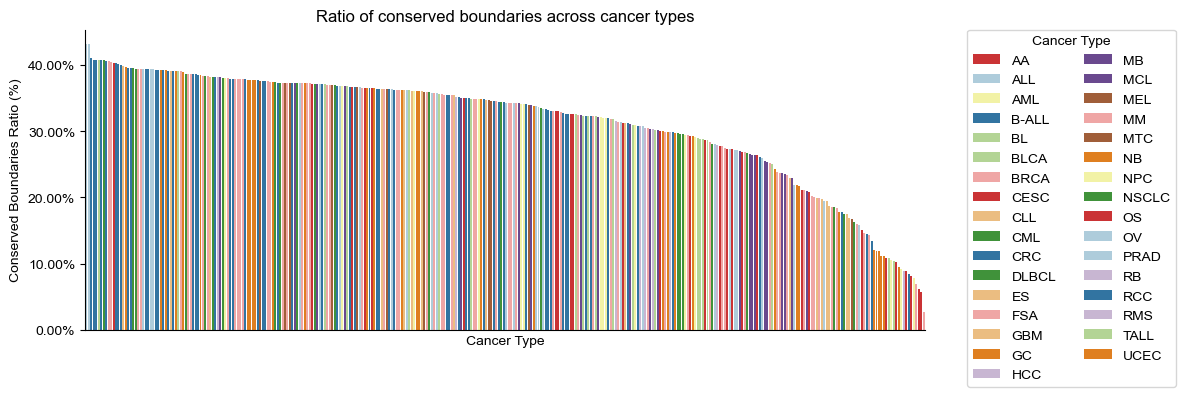

In [39]:
fig, ax = plt.subplots(figsize=(12, 4)) 
df=nCBmB_df.dropna() # 由于上面的问题删除 NA
# 使用 Paired 调色板，为每种癌症类型分配不同颜色
unique_cancers = df['cancer'].nunique()
set1 = sns.color_palette("Paired", unique_cancers)

# 创建条形图，按癌症类型上色
ax = sns.barplot(x=df.ncell, y=df['non_na_ratio'], 
                 hue=df['cancer'],  # 按癌症类型分组上色
                 palette=set1,      # 使用Paired调色板
                 dodge=False)       # 确保不分开显示

plt.title("Ratio of conserved boundaries across cancer types")
# plt.title("Number of boundaries across cancer types")
plt.xticks([])
plt.xlabel("Cancer Type")
plt.ylabel("Conserved Boundaries Ratio (%)")
sns.despine(top=True, right=True, left=False, bottom=False)

# plt.ylabel("Num of Boundaries")

# 将纵轴改为百分制
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.2%}'))

# 添加图例
handles, labels = ax.get_legend_handles_labels()

# 对标签和句柄同时排序（按字母顺序）
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))

# 重新设置 legend
ax.legend(handles, labels, title='Cancer Type',
          bbox_to_anchor=(1.05, 1), loc='upper left',
          borderaxespad=0, ncol=2)

plt.tight_layout()
plt.savefig('/cluster2/home/futing/Project/panCancer/Analysis/conserve/plot/412/panCan/strict/nCBmB_ratio_50k800k.pdf', dpi=500)

/tmp/ipykernel_103350/569123105.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['res']=df['res'].astype(int)


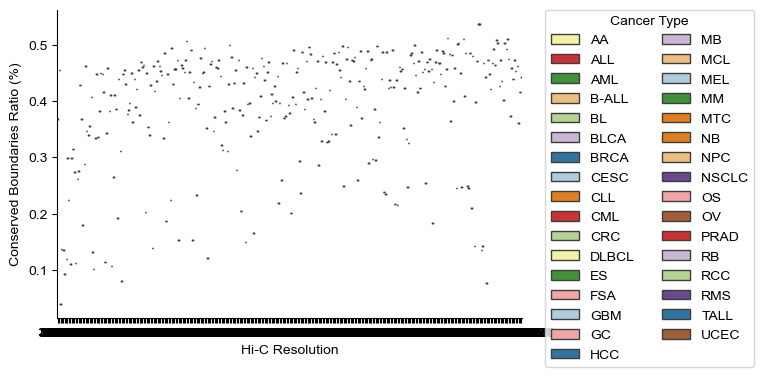

In [37]:
# res 与 conserve boundary ratio 关系
fig, ax = plt.subplots(figsize=(6, 4)) 
df=nCBmB_df.dropna() # 由于上面的问题删除 NA
df['res']=df['res'].astype(int)
sns.boxplot(data=df, x=df['res'].astype(int), y='non_na_ratio', palette=set1,hue='cancer')
plt.xlabel("Hi-C Resolution")
plt.ylabel("Conserved Boundaries Ratio (%)")
sns.despine(top=True, right=True, left=False, bottom=False)

# 添加图例
handles, labels = ax.get_legend_handles_labels()

# 对标签和句柄同时排序（按字母顺序）
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))

# 重新设置 legend
ax.legend(handles, labels, title='Cancer Type',
          bbox_to_anchor=(1.05, 1), loc='upper left',
          borderaxespad=0, ncol=2)

### Ctrl 的 BS

In [4]:
bin2=bin.drop(columns=resinfo.loc[resinfo['isctrl']==0,'ncell'].tolist(),errors='ignore') # 删除 normal 细胞系
bin2.shape,bin.shape #((61775, 358), (61775, 415))

((61776, 72), (61776, 415))

In [5]:
# 筛选 NA
threshold=0.5
# fil = bin1.notna().sum(axis=1) <= threshold*(bin.shape[1]) # 147.5 个细胞中存在视为保守。原本的，比较宽松，
fil = bin2.notna().sum(axis=1) >= threshold*(bin2.shape[1]-3) # 358-3/2=177.5 个细胞中存在视为保守
binctrl_fil = bin2.loc[fil,:] #(3061, 358) #(2255, 358)
binctrl_any = bin2.loc[bin2.notna().any(axis=1),:] # 所有的boundary (61776, 358)
print(f"Original bin shape: {bin2.shape}, After filtering NA > {threshold*100}% bin shape: {binctrl_fil.shape}, All boundary bin shape: {binctrl_any.shape}")

Original bin shape: (61776, 72), After filtering NA > 50.0% bin shape: (2467, 72), All boundary bin shape: (61776, 72)


In [6]:
binctrl_fil.to_csv('/cluster2/home/futing/Project/panCancer/Analysis/conserve/midata/412/Ctrl_50k800k',sep='\t',index=False)

In [7]:
# 计算每个细胞系有多少 conserve boundary
nCBctrl_ratio = binctrl_fil.iloc[:,3:].notna().sum(axis=0)
nCBctrl = binctrl_fil.shape[0]
# 注释一下
nCBctrl_df=pd.merge(nCBctrl_ratio.to_frame(name='non_na_ratio'), resinfo, left_index=True, right_on='ncell') # 合并 cancer 和 ncell 
nCBctrl_df= nCBctrl_df.sort_values(by='non_na_ratio', ascending=False) # 按照 non_na_ratio 排序

In [8]:
# 计算每个细胞系有多少 boundary
nBctrl_ratio = bin2.iloc[:,3:].notna().sum(axis=0)
# nCB_ratio.to_csv('/cluster2/home/futing/Project/panCancer/Analysis/conserve/nCB_50k800k.tsv', sep="\t", header=True)
nBctrl_df=pd.merge(nBctrl_ratio.to_frame(name='non_na_ratio'), resinfo, left_index=True, right_on='ncell') # 合并 cancer 和 ncell 
nBctrl_df= nBctrl_df.sort_values(by='non_na_ratio', ascending=False) # 按照 non_na_ratio 排序

In [9]:
# 每个细胞系 conserve boundary 的数量/每个细胞系 boundary 的数量 = conserve boundary ratio
nCBmBctrl_ratio = binctrl_fil.iloc[:,3:].notna().sum(axis=0) / bin2.iloc[:,3:].notna().sum(axis=0)
nCBmBctrl_df=pd.merge(nCBmBctrl_ratio.to_frame(name='non_na_ratio'), resinfo, left_index=True, right_on='ncell',how='inner') # 合并 cancer 和 ncell 
nCBmBctrl_df= nCBmBctrl_df.sort_values(by='non_na_ratio', ascending=False) # 按照 non_na_ratio 排序

In [11]:
# 合并所有的统计数据
CBctrl_data = pd.DataFrame({
	'nCBpercell': nCBctrl_ratio,
	'nCB': nCBctrl,
	'nB': nBctrl_ratio,
	'nCBmB_ratio': nCBmBctrl_ratio,

})
CBctrl_data = CBctrl_data.reset_index().rename(columns={'index': 'ncell'})
CBctrl_data = CBctrl_data.merge(resinfo, on='ncell', how='inner')
CBctrl_data = CBctrl_data.sort_values(by='nCBmB_ratio', ascending=True)
CBctrl_data=CBctrl_data.dropna()

In [15]:
CBctrl_data.to_csv("./midata/412/CBctrl_data_50k800k.tsv",sep='\t',index=False)

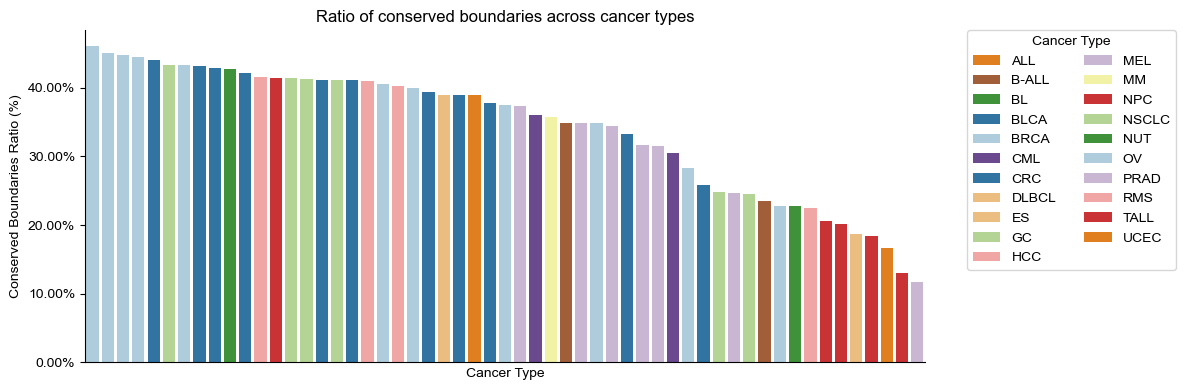

In [17]:
fig, ax = plt.subplots(figsize=(12, 4)) 
df=nCBmBctrl_df.dropna() # 由于上面的问题删除 NA
# 使用 Paired 调色板，为每种癌症类型分配不同颜色
unique_cancers = df['cancer'].nunique()
set1 = sns.color_palette("Paired", unique_cancers)

# 创建条形图，按癌症类型上色
ax = sns.barplot(x=df.ncell, y=df['non_na_ratio'], 
                 hue=df['cancer'],  # 按癌症类型分组上色
                 palette=set1,      # 使用Paired调色板
                 dodge=False)       # 确保不分开显示

plt.title("Ratio of conserved boundaries across cancer types")
# plt.title("Number of boundaries across cancer types")
plt.xticks([])
plt.xlabel("Cancer Type")
plt.ylabel("Conserved Boundaries Ratio (%)")
sns.despine(top=True, right=True, left=False, bottom=False)

# plt.ylabel("Num of Boundaries")

# 将纵轴改为百分制
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.2%}'))

# 添加图例
handles, labels = ax.get_legend_handles_labels()

# 对标签和句柄同时排序（按字母顺序）
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))

# 重新设置 legend
ax.legend(handles, labels, title='Cancer Type',
          bbox_to_anchor=(1.05, 1), loc='upper left',
          borderaxespad=0, ncol=2)

plt.tight_layout()
plt.savefig('./plot/nCBmBctrl_ratio_50k800k.pdf', dpi=500)

In [66]:
rCB_Cvct=pd.concat([	pd.DataFrame({
		'rCB':nCBmB_ratio,
		'type':'CANCER'
	}),
	pd.DataFrame({
		'rCB':nCBmBctrl_ratio,
		'type':'CTRL'
	})],ignore_index=True

).dropna()
# rCB_Cvct['rCB']=rCB_Cvct['rCB']*100

In [59]:
def add_stat_annotation(ax, x1, x2, y, p_value, line_height=0.02):
    """添加统计标注的通用函数"""
    
    # 计算星号标记
    if p_value < 0.001:
        p_text = '***'
    elif p_value < 0.01:
        p_text = '**'
    elif p_value < 0.05:
        p_text = '*'
    else:
        p_text = f'p = {p_value:.3f}'
    
    # 绘制横杠
    h = y * line_height
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], 
            lw=1.5, color='black', marker='')
    
    # 添加文本
    ax.text((x1+x2)*0.5, y+h, p_text, 
            ha='center', va='bottom', 
            fontsize=12, fontweight='bold')

/tmp/ipykernel_98693/2721569846.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=rCB_Cvct, x='type', y='rCB',


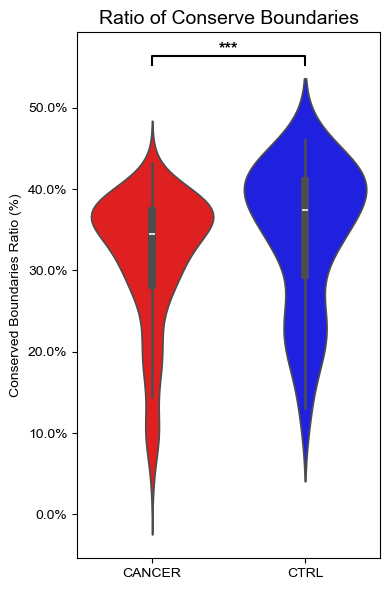

In [68]:
plt.figure(figsize=(4, 6))

ax = sns.violinplot(data=rCB_Cvct, x='type', y='rCB',
                   palette=['red', 'blue'])

# 计算p值
_, p_value = stats.mannwhitneyu(cancer_data, ctrl_data)
cancer_data = rCB_Cvct[rCB_Cvct['type']=='CANCER']['rCB']
ctrl_data = rCB_Cvct[rCB_Cvct['type']=='CTRL']['rCB']
# 添加标注
y_max = rCB_Cvct['rCB'].max()
add_stat_annotation(ax, 0, 1, y_max*1.2, p_value)

ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.1%}'))
plt.title('Ratio of Conserve Boundaries', fontsize=14)
plt.ylabel("Conserved Boundaries Ratio (%)")
plt.xlabel("")
plt.tight_layout()
plt.savefig('./plot/CanVSCtrl_nCBmB_50k800k.pdf', dpi=500)

/tmp/ipykernel_98693/1728107228.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=rCB_Cvct, x='type', y='rCB',


CANCER vs. CTRL: Custom statistical test, P_val:2.051e-04


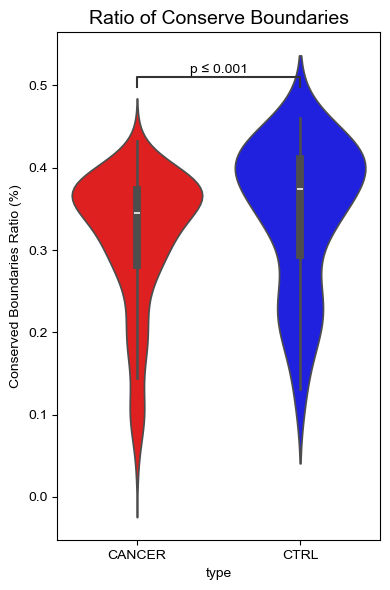

In [ ]:
from scipy import stats
from statannotations.Annotator import Annotator

plt.figure(figsize=(4, 6))
ax = sns.violinplot(data=rCB_Cvct, x='type', y='rCB',
                   palette=['red', 'blue'])

# 进行t检验
cancer_data = rCB_Cvct[rCB_Cvct['type']=='CANCER']['rCB']
ctrl_data = rCB_Cvct[rCB_Cvct['type']=='CTRL']['rCB']
u_stat, p_value = stats.mannwhitneyu(cancer_data, ctrl_data, alternative='two-sided')
# t_stat, p_value = stats.ttest_ind(cancer_data, ctrl_data)
# print(f"曼-惠特尼U检验: U = {u_stat:.4f}, p = {p_value:.4f}")
pairs = [("CANCER", "CTRL")]
pvalues = [p_value]  # 使用你计算出的p值

# 添加统计标注
annotator = Annotator(ax, pairs, data=rCB_Cvct, x='type', y='rCB')
annotator.configure(text_format='simple', loc='inside')
annotator.set_pvalues(pvalues)
annotator.annotate()

# # 添加p值标注
# plt.text(0.5, plt.ylim()[1]*0.9, f'p-value = {p_value:.4f}', 
#          ha='center', fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="white"))
plt.title('Ratio of Conserve Boundaries', fontsize=14)
plt.ylabel("Conserved Boundaries Ratio (%)")
plt.tight_layout()
# plt.savefig('./plot/CanVSCtrl_nCBmB_50k800k.pdf', dpi=500)